# Faster R-CNN in Pytorch

In [ ]:
#https://colab.research.google.com/notebooks/pro.ipynb
#https://arxiv.org/pdf/1506.01497

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch#Installs-and-Imports

In [ ]:
# references/detection
#!pip install pycocotools --quiet
#!git clone https://github.com/pytorch/vision.git
#%cd vision
#!git checkout v0.3.0

Cloning into 'vision'...
remote: Enumerating objects: 583335, done.
remote: Counting objects: 100% (31121/31121), done.
remote: Compressing objects: 100% (1819/1819), done.
remote: Total 583335 (delta 29121), reused 31013 (delta 29082), pack-reused 552214 (from 1)
Receiving objects: 100% (583335/583335), 1.09 GiB | 14.77 MiB/s, done.
Resolving deltas: 100% (545210/545210), done.
/content/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch'

In [ ]:
#!pip uninstall torchvision -y # uninstall the torchvision installed in cloned module
#!pip install torchvision

In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# these are the helper libraries imported.
import sys
import os
sys.path.append('/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN')


# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

# Now you can import the modules without the syntax error
from engine import train_one_epoch, evaluate
from utils import *  # or specify the functions/classes you need
import transforms as T


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Load Images

**Note:** The annotations should also contain the corresponding image path

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from skimage import io
import xml.etree.ElementTree as ET


class ObjectDetectionDataset(Dataset):
    """
    A PyTorch Dataset class to load images and their corresponding XML annotations.

    Returns
    ------------
    image: torch.Tensor of shape [3, H, W] (a pure tensor or PIL Image)
    target: dict containing the following fields:
        - boxes: torch.Tensor of shape [N, 4] in [x_min, y_min, x_max, y_max] format
        - labels: torch.Tensor of shape [N], with 0 as background class
        - image_id: int, unique identifier for the image
        - area: torch.Tensor of shape [N], area of each bounding box
        - iscrowd: torch.Tensor of shape [N], 0 for most cases (1 for crowd annotations)
    """

    def __init__(self, img_dir, name2idx, img_size, transform=None):
        self.img_dir = img_dir
        self.name2idx = name2idx
        self.img_size = img_size  # Target image size (H, W)
        self.transform = transform  # Transformations to be applied

        # Get valid file pairs (ignoring files with no bounding boxes)
        self.img_paths, self.ann_paths = self._filter_valid_files()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]

        # Load image
        img = io.imread(img_path)
        original_height, original_width = img.shape[:2]

        # Resize image to target size
        img = F.to_tensor(F.resize(F.to_pil_image(img), self.img_size))

        # Parse annotation
        gt_bboxes, gt_classes = self._parse_annotation(ann_path)

        # Calculate scaling factors
        scale_x = self.img_size[1] / original_width
        scale_y = self.img_size[0] / original_height

        # Adjust bounding boxes according to new image size
        gt_bboxes = torch.tensor([
            [x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y]
            for (x_min, y_min, x_max, y_max) in gt_bboxes
        ], dtype=torch.float32)

        # Compute area of each bounding box
        area = (gt_bboxes[:, 2] - gt_bboxes[:, 0]) * (gt_bboxes[:, 3] - gt_bboxes[:, 1])

        # Prepare target dictionary
        target = {
            "boxes": gt_bboxes,
            "labels": torch.tensor([self.name2idx[cls] for cls in gt_classes], dtype=torch.long),
            "image_id": torch.tensor([idx]),
            "area": area,
            "iscrowd": torch.zeros(len(gt_bboxes), dtype=torch.uint8)  # Default iscrowd = 0
        }

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def _filter_valid_files(self):
        """
        Filter out files that have no bounding boxes.
        """
        valid_img_paths, valid_ann_paths = [], []
        for file in os.listdir(self.img_dir):
            if file.endswith(".jpg"):
                img_path = os.path.join(self.img_dir, file)
                ann_path = img_path.replace(".jpg", ".xml")

                if os.path.exists(ann_path):
                    bboxes, _ = self._parse_annotation(ann_path)
                    if bboxes:  # Only add files with at least one bounding box
                        valid_img_paths.append(img_path)
                        valid_ann_paths.append(ann_path)
        return valid_img_paths, valid_ann_paths

    def _parse_annotation(self, ann_path):
        """
        Parse the XML file to extract bounding boxes and class labels.
        """
        tree = ET.parse(ann_path)
        root = tree.getroot()

        bboxes = []
        classes = []

        for obj in root.findall("object"):
            cls_name = obj.find("name").text.lower()
            bbox = obj.find("bndbox")
            x_min = int(bbox.find("xmin").text)
            y_min = int(bbox.find("ymin").text)
            x_max = int(bbox.find("xmax").text)
            y_max = int(bbox.find("ymax").text)

            bboxes.append([x_min, y_min, x_max, y_max])
            classes.append(cls_name)

        return bboxes, classes


In [ ]:
home = '/content/drive/MyDrive/ColabNotebooks/FasterRCNN'

In [ ]:
'''
# Function to process XML files
def process_xml_files(xml_dir):
    found_names = []

    # Loop through all XML files in the directory
    for filename in os.listdir(xml_dir):
        if filename.endswith('.xml'):
            file_path = os.path.join(xml_dir, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Assuming the name is stored in a specific tag, e.g., <name>
            for member in root.findall('object'):
                name = member.find('name').text  # Adjust the tag as needed
                #if name in name2idx:
                found_names.append(name)

    return found_names

xml_directory = '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/Order/train'
names_found = process_xml_files(xml_directory)

# Output the results
print("Found names:", set(names_found))
#print("Mapped indices:", mapped_indices)
'''

'\n# Function to process XML files\ndef process_xml_files(xml_dir):\n    found_names = []\n\n    # Loop through all XML files in the directory\n    for filename in os.listdir(xml_dir):\n        if filename.endswith(\'.xml\'):\n            file_path = os.path.join(xml_dir, filename)\n            tree = ET.parse(file_path)\n            root = tree.getroot()\n\n            # Assuming the name is stored in a specific tag, e.g., <name>\n            for member in root.findall(\'object\'):\n                name = member.find(\'name\').text  # Adjust the tag as needed\n                #if name in name2idx:\n                found_names.append(name)\n\n    return found_names\n\nxml_directory = \'/content/drive/MyDrive/ColabNotebooks/FasterRCNN/Order/train\'\nnames_found = process_xml_files(xml_directory)\n\n# Output the results\nprint("Found names:", set(names_found))\n#print("Mapped indices:", mapped_indices)\n'

#### Create Dataset and Dataloaders

In [ ]:
name2idx = {'pad': 0,'laptop': 1,'computer keyboard':2, 'keyboard':2, 'computer mouse':3, 'mouse': 3, 'spoon':4, 'fork':5}  # Map class names to indices
idx2name = {v:k for k, v in name2idx.items()}
img_width = 224
img_height = 224

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/Order/train'
val_dir = '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/Order/valid'
test_dir = '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/Order/test'

#dataset = ObjectDetectionDataset(img_dir=train_dir, name2idx=name2idx, img_size=(img_width, img_height))
#img, target = dataset[800]
#print(img.shape)  # Should print: torch.Size([3, 224, 224])
#print(target)     # Bounding boxes for the first image

## Plot Multiple

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_img_bbox(img, annotation, ax=None, is_prediction=False):
    """
    Plots bounding boxes and labels on an image.

    Parameters:
        img (Tensor): Image tensor (C, H, W).
        annotation (dict): Dictionary with 'boxes' and 'labels' (and 'scores' if predictions).
        ax (matplotlib axis): Axis to plot on.
        is_prediction (bool): Whether the annotation is a prediction (includes 'scores').
    """
    # Move image to CPU and permute to (H, W, C) for plotting
    img = img.cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # Create a new figure/axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 8))

    ax.imshow(img)

    # Extract boxes, labels, and scores (if available)
    boxes = annotation['boxes'].cpu()
    labels = annotation['labels'].cpu()
    scores = annotation.get('scores', None)  # Use .get() to avoid KeyError

    # Plot each bounding box
    for i, (box, label) in enumerate(zip(boxes, labels)):
        x_min, y_min, x_max, y_max = box

        # Draw the rectangle
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        # Map label ID to name
        class_name = idx2name.get(label.item(), 'Unknown')

        # Prepare text: Include score if it's a prediction
        if is_prediction and scores is not None:
            text = f"{class_name}: {scores[i].item():.2f}"
        else:
            text = class_name

        # Add label (and score if available)
        ax.text(
            x_min, y_min - 10, text,
            color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5)
        )

    ax.axis('off')  # Turn off axis

'''
# Example usage: plotting a grid of 4 images with their bounding boxes
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Create a 2x2 grid of subplots
axs = axs.flatten()  # Flatten the 2D array of axes to easily iterate

# Change the range for your dataset
for i in range(4):
    img, target = dataset[i*50]  # Get the image and target from your dataset
    plot_img_bbox(img, target, axs[i])  # Plot each image with bounding boxes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
'''

'\n# Example usage: plotting a grid of 4 images with their bounding boxes\nfig, axs = plt.subplots(2, 2, figsize=(14, 14))  # Create a 2x2 grid of subplots\naxs = axs.flatten()  # Flatten the 2D array of axes to easily iterate\n\n# Change the range for your dataset\nfor i in range(4):\n    img, target = dataset[i*50]  # Get the image and target from your dataset\n    plot_img_bbox(img, target, axs[i])  # Plot each image with bounding boxes\n\nplt.tight_layout()  # Adjust layout to prevent overlap\nplt.show()\n'

### Plot simple

In [ ]:
#img, target = dataset[21]
#plot_img_bbox(img, target)

## Convolutional Backbone Network

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT") #pretrained=True

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

#import transforms as T
from torchvision.transforms import v2 as Tr
def get_transform(train):
    transforms = []
    if train:
        transforms.append(Tr.RandomHorizontalFlip(0.5))
    transforms.append(Tr.ToDtype(torch.float, scale=True))
    transforms.append(Tr.ToPureTensor())
    return T.Compose(transforms)


### Test the model initially

In [ ]:
'''
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
images, targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])
'''

'\ndataloader = torch.utils.data.DataLoader(\n    dataset,\n    batch_size=2,\n    shuffle=True,\n    collate_fn=utils.collate_fn\n)\n\n\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")\nimages, targets = next(iter(dataloader))\nimages = list(image for image in images)\ntargets = [{k: v for k, v in t.items()} for t in targets]\noutput = model(images, targets)  # Returns losses and detections\nprint(output)\n\n# For inference\nmodel.eval()\nx = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]\npredictions = model(x)  # Returns predictions\nprint(predictions[0])\n'

### Train the model

First perform a train test split

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN')

try:
    import utils
    from engine import train_one_epoch, evaluate
    print("Utils module path:", utils.__file__)
    print("Available functions and classes in utils:", dir(utils))
except ImportError as e:
    print("Error importing utils:", e)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6

# use our dataset and defined transformations
dataset = ObjectDetectionDataset(img_dir=train_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=True))
dataset_test = ObjectDetectionDataset(img_dir=train_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=False))
dataset_valid = ObjectDetectionDataset(img_dir=val_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

print(f'Training set size: {len(dataset)}')
print(f'Validation set size: {len(dataset_test)}')


Utils module path: /content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN/utils.py
Available functions and classes in utils: ['MetricLogger', 'SmoothedValue', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'all_gather', 'collate_fn', 'datetime', 'defaultdict', 'deque', 'dist', 'errno', 'get_rank', 'get_world_size', 'init_distributed_mode', 'is_dist_avail_and_initialized', 'is_main_process', 'mkdir', 'os', 'pickle', 'print_function', 'reduce_dict', 'save_on_master', 'setup_for_distributed', 'time', 'torch', 'warmup_lr_scheduler']
Training set size: 1732
Validation set size: 433


In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=16,
    shuffle=False,
    #drop_last=True,
    collate_fn=utils.collate_fn
)


In [ ]:
for i in range(len(data_loader_test.dataset)):
    try:
        data = data_loader_test.dataset[i]
    except Exception as e:
        print(f"Error at index {i}: {e}")

Train the model

In [ ]:
# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.004,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/109]  eta: 0:01:10  lr: 0.000041  loss: 2.2119 (2.2119)  loss_classifier: 1.9928 (1.9928)  loss_box_reg: 0.1908 (0.1908)  loss_objectness: 0.0137 (0.0137)  loss_rpn_box_reg: 0.0146 (0.0146)  time: 0.6425  data: 0.1916  max mem: 19389
Epoch: [0]  [ 10/109]  eta: 0:01:01  lr: 0.000411  loss: 1.7599 (1.5539)  loss_classifier: 1.5260 (1.3380)  loss_box_reg: 0.1819 (0.1777)  loss_objectness: 0.0248 (0.0269)  loss_rpn_box_reg: 0.0091 (0.0113)  time: 0.6241  data: 0.1953  max mem: 19389
Epoch: [0]  [ 20/109]  eta: 0:00:56  lr: 0.000781  loss: 0.5761 (1.0542)  loss_classifier: 0.3380 (0.8341)  loss_box_reg: 0.1658 (0.1723)  loss_objectness: 0.0248 (0.0363)  loss_rpn_box_reg: 0.0091 (0.0114)  time: 0.6306  data: 0.2034  max mem: 19389
Epoch: [0]  [ 30/109]  eta: 0:00:49  lr: 0.001151  loss: 0.4736 (0.8694)  loss_classifier: 0.2798 (0.6552)  loss_box_reg: 0.1514 (0.1697)  loss_objectness: 0.0239 (0.0337)  loss_rpn_box_reg: 0.0093 (0.0108)  time: 0.6334  data: 0.2058  max mem: 19

In [ ]:
torch.save(model.state_dict(), 'faster_rcnn_v1_6class_alejandroparedeslatorre.pt')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
!cp -r '/content/faster_rcnn_v1_6class_alejandroparedeslatorre.pt' '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN'

Evaluation

Mean IoU: 0.8350
F1 Score: 0.8716


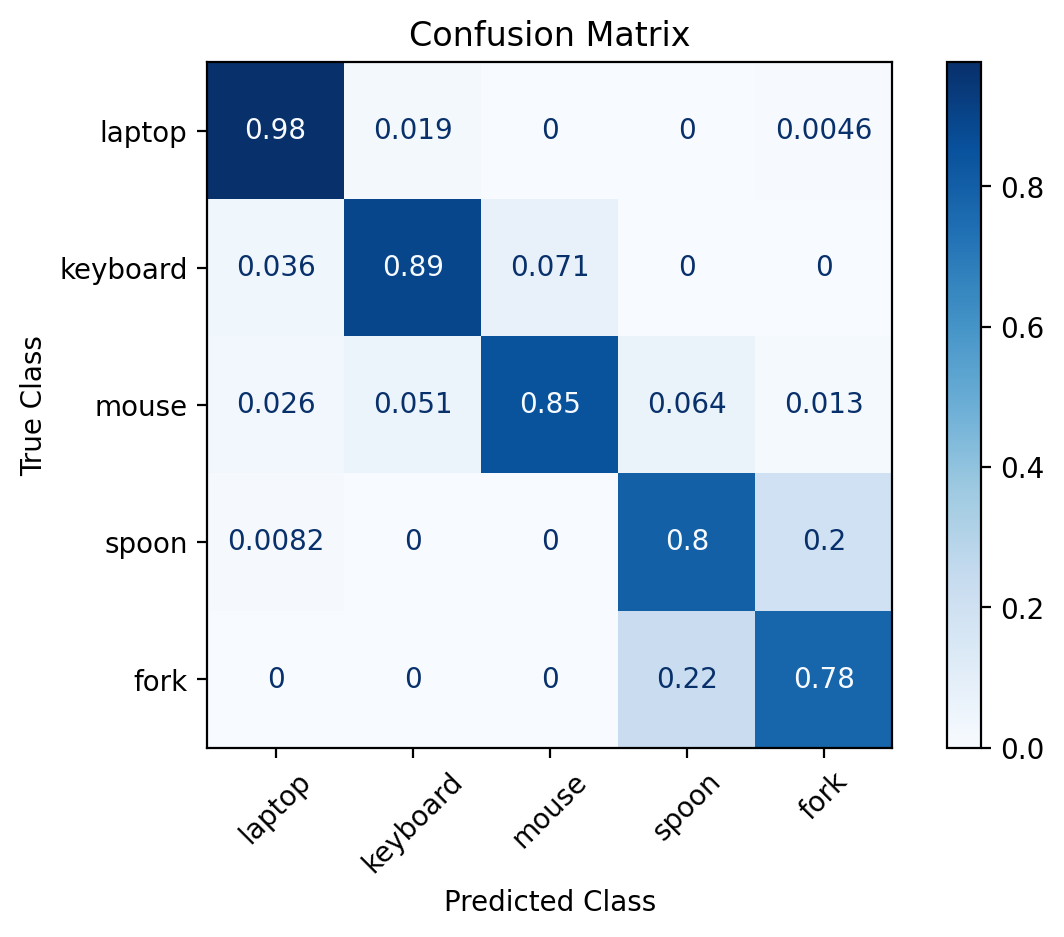

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_collect(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    iou_scores = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                true_boxes = targets[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()

                # For each true box, find the predicted box with the highest IoU
                for true_box, true_label in zip(true_boxes, true_labels):
                    best_iou = 0
                    best_pred_label = None

                    for j, pred_box in enumerate(pred_boxes):
                        iou = calculate_iou_single(pred_box, true_box)  # IoU for a single box
                        if iou > best_iou:  # Select the box with the highest IoU
                            best_iou = iou
                            best_pred_label = pred_labels[j]

                    # Collect the best prediction and corresponding true label
                    if best_pred_label is not None:
                        all_preds.append(best_pred_label)
                        all_labels.append(true_label)
                        iou_scores.append(best_iou)

    return all_preds, all_labels, iou_scores

def calculate_iou_single(pred_box, true_box):
    # Compute intersection
    x1 = max(pred_box[0], true_box[0])
    y1 = max(pred_box[1], true_box[1])
    x2 = min(pred_box[2], true_box[2])
    y2 = min(pred_box[3], true_box[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    true_area = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
    union = pred_area + true_area - intersection

    return intersection / union if union > 0 else 0  # Avoid division by zero

# Collect predictions, targets, and IoU scores from the evaluation function
all_preds, all_labels, iou_scores = evaluate_and_collect(model, data_loader_test, device)

# Compute F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Create a list of class names based on the index
class_names = [idx2name[i] for i in range(1, len(idx2name))]  # Exclude index 0

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(all_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

# Set the tick labels to class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()  # Adjust layout for better fit
plt.show()

Plot examples of results

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction



# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
for i in  range(1, 300, 50):
    # pick one image from the test set
    img, target = dataset_test[i]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))

predicted #boxes:  15
real #boxes:  1
predicted #boxes:  25
real #boxes:  2
predicted #boxes:  3
real #boxes:  1
predicted #boxes:  20
real #boxes:  1
predicted #boxes:  13
real #boxes:  1
predicted #boxes:  4
real #boxes:  1


In [ ]:
# Pick one image from the test set
img, target = dataset_test[10]

# Put the model in evaluation mode
model.eval()

# Ensure no gradients are calculated
with torch.no_grad():
    # Move the input image to the same device as the model
    img = img.to(device)
    prediction = model([img])[0]

# Move the prediction and target tensors to CPU for printing
pred_labels = prediction['labels'].cpu()
target_labels = target['labels'].cpu()

print('Predicted #boxes:', len(pred_labels))
print('Real #boxes:', len(target_labels))

Predicted #boxes: 7
Real #boxes: 1


EXPECTED OUTPUT


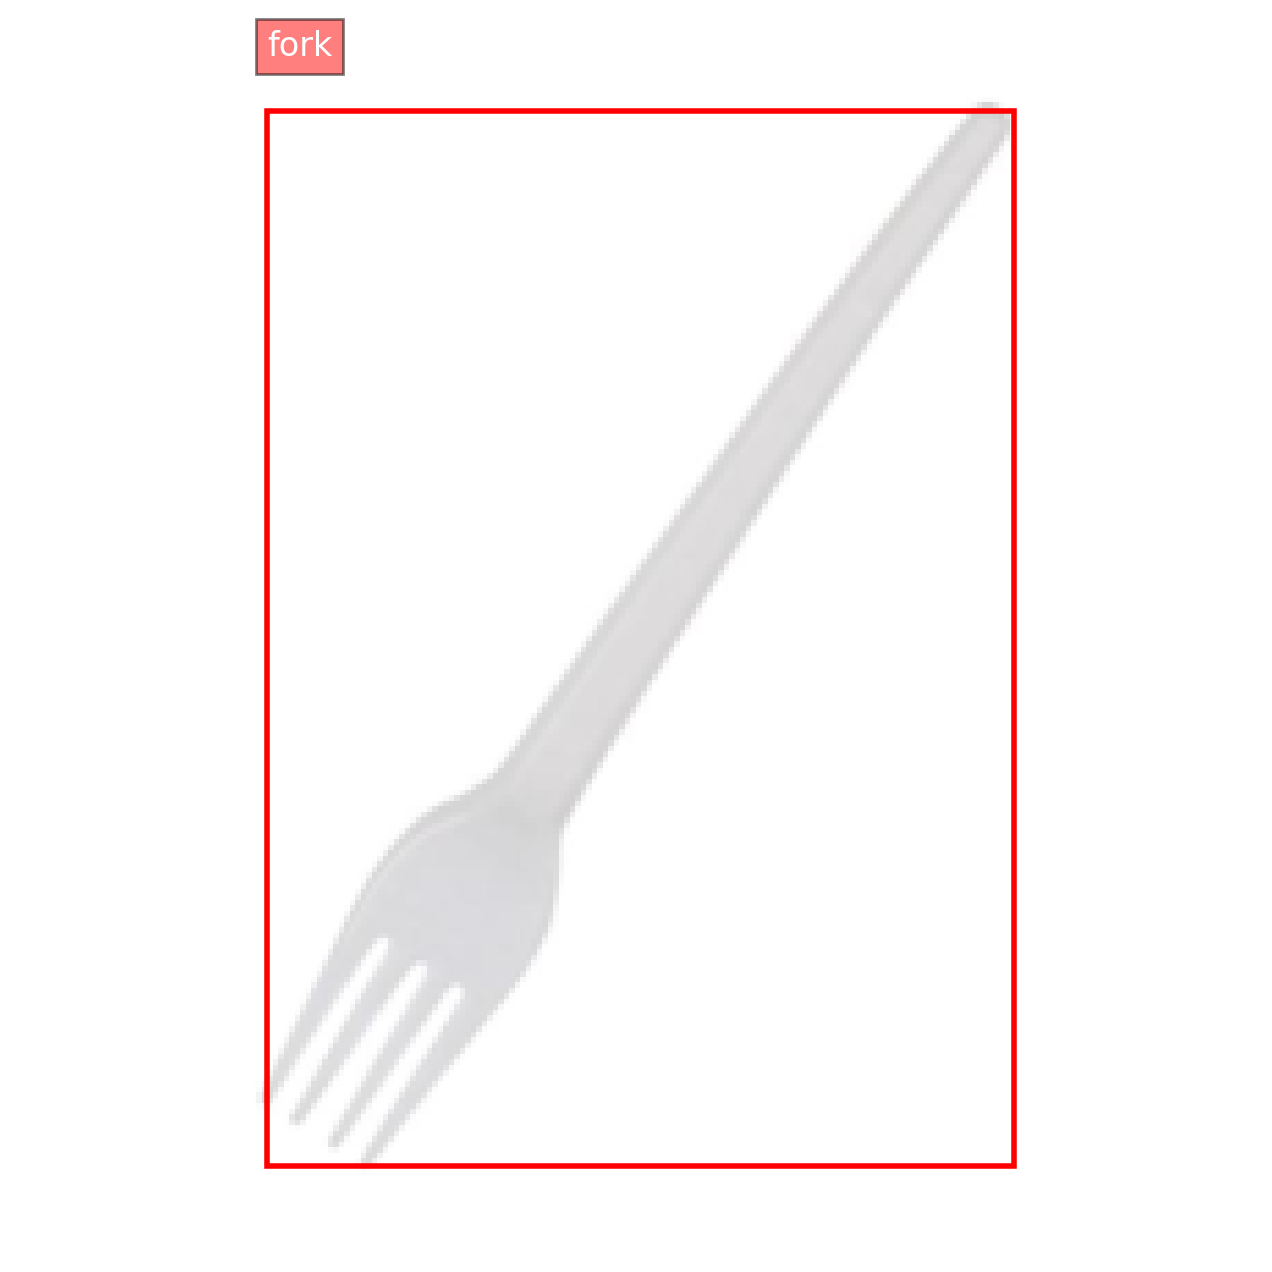

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

MODEL OUTPUT


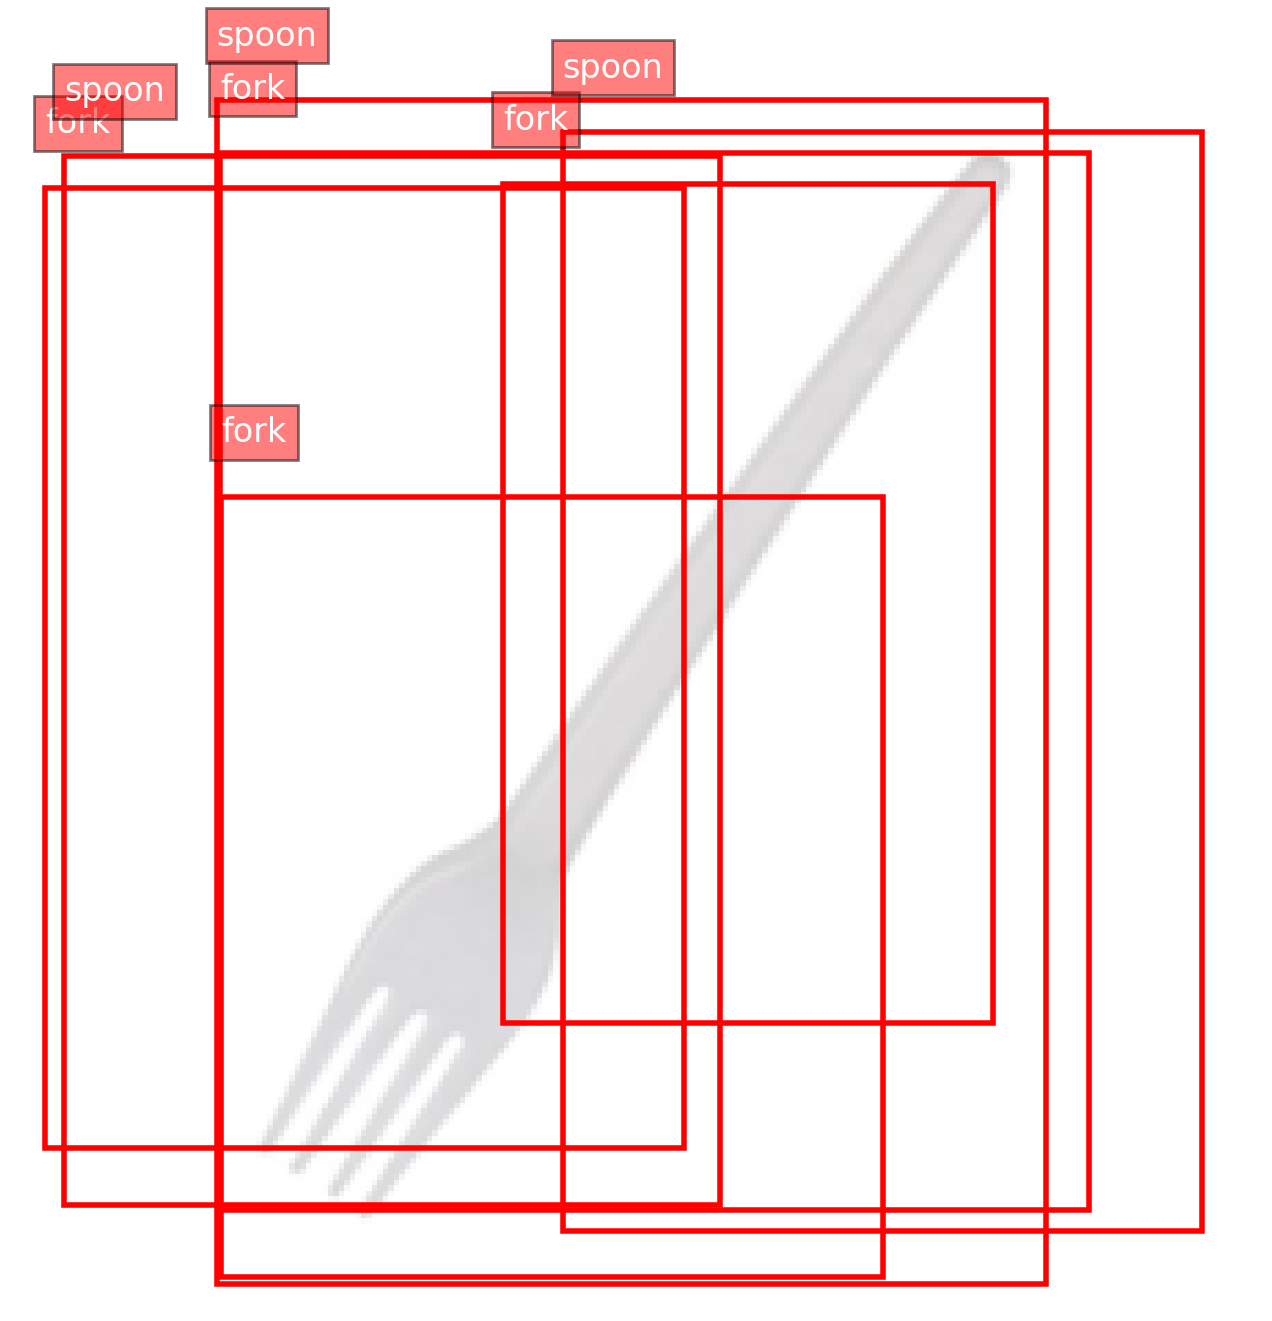

In [ ]:
img, target = dataset_test[10]
model.eval()
with torch.no_grad():
    img = img.to(device)
    prediction = model([img])[0]

print('MODEL OUTPUT')
plot_img_bbox(img, prediction)


NMS APPLIED MODEL OUTPUT


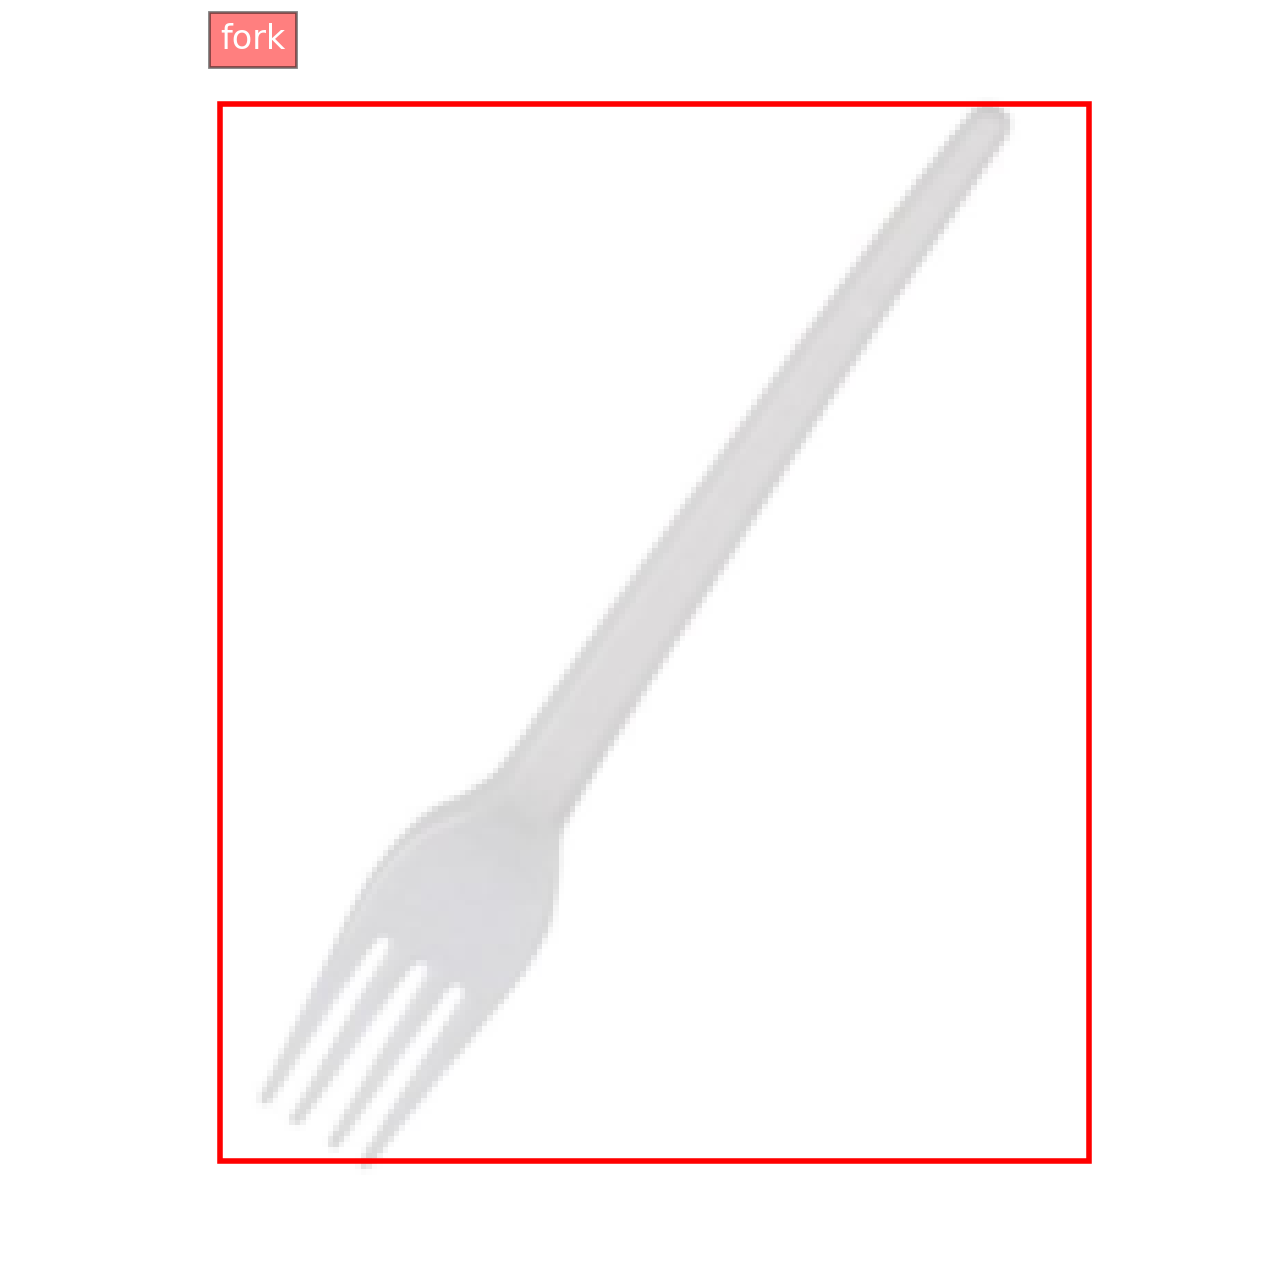

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.05)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img, nms_prediction)

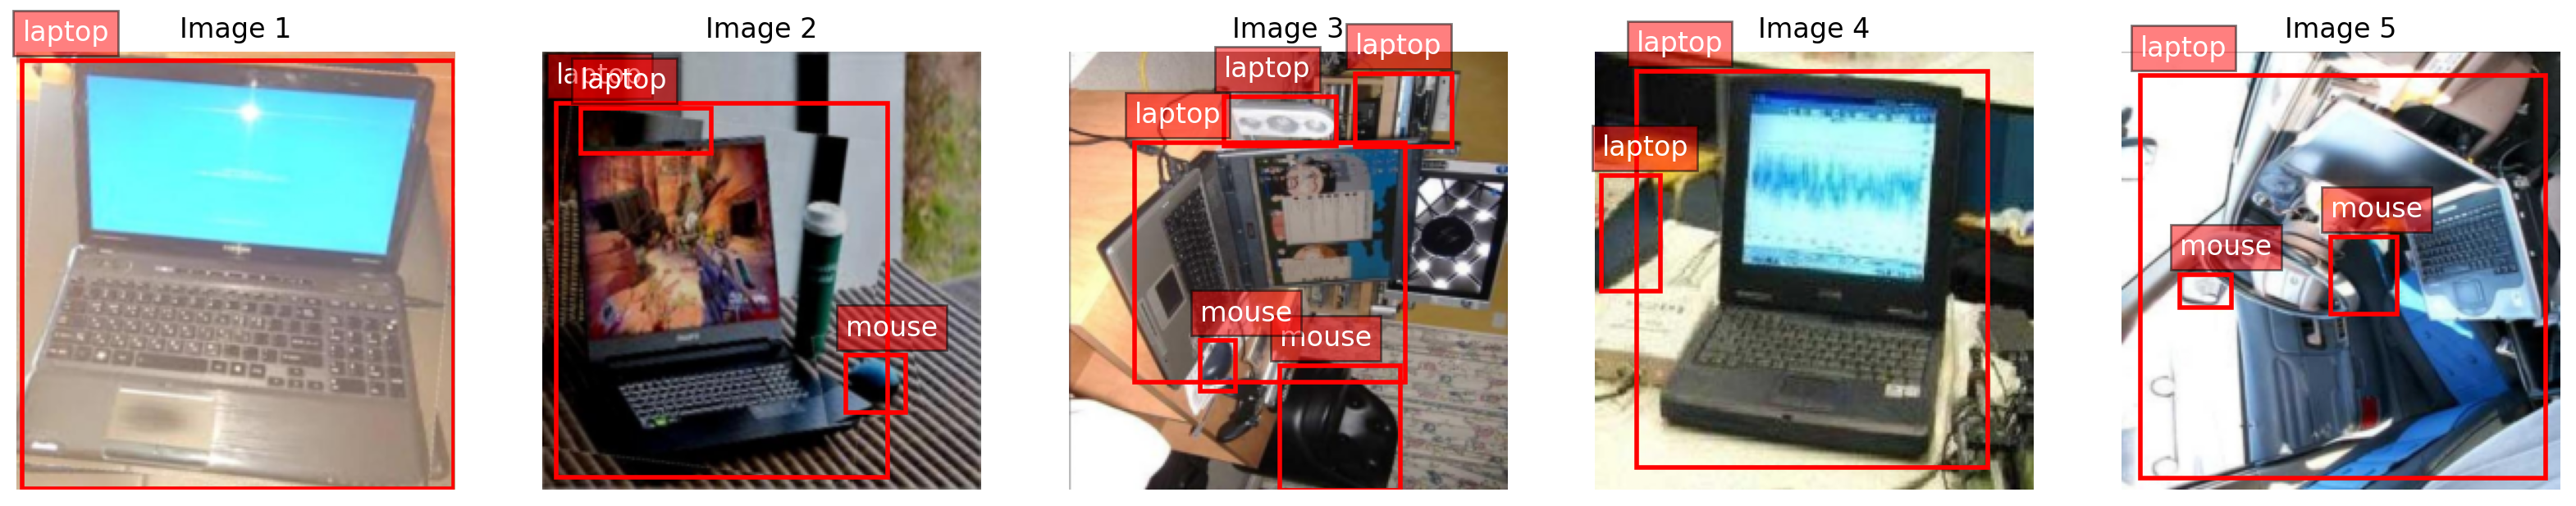

In [ ]:
# Load the model and set it to evaluation mode
model.eval()

def plot_examples(dataset, model, device, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(20, 5))

    for i in range(num_examples):
        # Get the image and move it to the appropriate device
        image, target = dataset[i]
        x = image.to(device).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            predictions = model(x)

        # Apply NMS to the predictions
        nms_pred = apply_nms(predictions[0], iou_thresh=0.05)

        # Plot the image and predictions on the corresponding axis
        plot_img_bbox(image, nms_pred, ax=axes[i])
        axes[i].set_title(f"Image {i+1}")

    plt.show()

# Call the function to plot 5 examples
plot_examples(dataset_valid, model, device, num_examples=5)

## Improved Fast RCNN

In [ ]:
def get_object_detection_model_v2(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT") #pretrained=True

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


from torchvision.transforms import v2 as Tr
from torchvision import transforms
import torch

def get_transform(train=True):
  transforms = []
  if train:
    transforms.append(Tr.RandomHorizontalFlip(0.5))
    transforms.append(Tr.RandomRotation(30))
    transforms.append(Tr.RandomPerspective(distortion_scale=0.4))
    transforms.append(Tr.RandomHorizontalFlip(0.6))
    #transforms.append(Tr.RandomVerticalFlip(0.5))

  transforms.append(Tr.ToDtype(torch.float, scale=True))
  transforms.append(Tr.ToPureTensor())
  return T.Compose(transforms)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN')

try:
    import utils
    from engine import train_one_epoch, evaluate
    print("Utils module path:", utils.__file__)
    print("Available functions and classes in utils:", dir(utils))
except ImportError as e:
    print("Error importing utils:", e)

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6

# use our dataset and defined transformations
dataset = ObjectDetectionDataset(img_dir=train_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=True))
dataset_test = ObjectDetectionDataset(img_dir=train_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=False))
dataset_valid = ObjectDetectionDataset(img_dir=val_dir, name2idx=name2idx, img_size=(img_width, img_height), transform=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

print(f'Training set size: {len(dataset)}')
print(f'Validation set size: {len(dataset_test)}')

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=16,
    shuffle=False,
    #drop_last=True,
    collate_fn=utils.collate_fn
)


Utils module path: /content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN/utils.py
Available functions and classes in utils: ['MetricLogger', 'SmoothedValue', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'all_gather', 'collate_fn', 'datetime', 'defaultdict', 'deque', 'dist', 'errno', 'get_rank', 'get_world_size', 'init_distributed_mode', 'is_dist_avail_and_initialized', 'is_main_process', 'mkdir', 'os', 'pickle', 'print_function', 'reduce_dict', 'save_on_master', 'setup_for_distributed', 'time', 'torch', 'warmup_lr_scheduler']
Training set size: 1732
Validation set size: 433


In [ ]:
# get the model using our helper function
model_v2 = get_object_detection_model_v2(num_classes)

# move model to the right device
model_v2.to(device)

# construct an optimizer
params = [p for p in model_v2.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.004,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


num_epochs = 10
metrics = []  # Store accuracy if you want to track it

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_v2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_evaluator = evaluate(model_v2, data_loader_test, device=device)
    metrics.append(coco_evaluator)

print("That's it!")

Epoch: [0]  [  0/109]  eta: 0:01:51  lr: 0.000041  loss: 1.9824 (1.9824)  loss_classifier: 1.8025 (1.8025)  loss_box_reg: 0.1002 (0.1002)  loss_objectness: 0.0641 (0.0641)  loss_rpn_box_reg: 0.0155 (0.0155)  time: 1.0259  data: 0.3841  max mem: 19389
Epoch: [0]  [ 10/109]  eta: 0:01:25  lr: 0.000411  loss: 1.8721 (1.7379)  loss_classifier: 1.6368 (1.5199)  loss_box_reg: 0.1169 (0.1204)  loss_objectness: 0.0753 (0.0810)  loss_rpn_box_reg: 0.0155 (0.0165)  time: 0.8616  data: 0.2956  max mem: 19483
Epoch: [0]  [ 20/109]  eta: 0:01:15  lr: 0.000781  loss: 1.0754 (1.1682)  loss_classifier: 0.7852 (0.9568)  loss_box_reg: 0.1186 (0.1202)  loss_objectness: 0.0733 (0.0753)  loss_rpn_box_reg: 0.0140 (0.0158)  time: 0.8367  data: 0.2792  max mem: 19483
Epoch: [0]  [ 30/109]  eta: 0:01:06  lr: 0.001151  loss: 0.3945 (0.9200)  loss_classifier: 0.1906 (0.7102)  loss_box_reg: 0.1262 (0.1224)  loss_objectness: 0.0635 (0.0717)  loss_rpn_box_reg: 0.0137 (0.0158)  time: 0.8297  data: 0.2727  max mem: 19

In [ ]:
torch.save(model_v2.state_dict(), 'faster_rcnn_v2_6class_alejandroparedeslatorre.pt')
print("Model saved successfully!")

!cp -r '/content/faster_rcnn_v2_6class_alejandroparedeslatorre.pt' '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN'

Model saved successfully!


Mean IoU: 0.7665
F1 Score: 0.8159


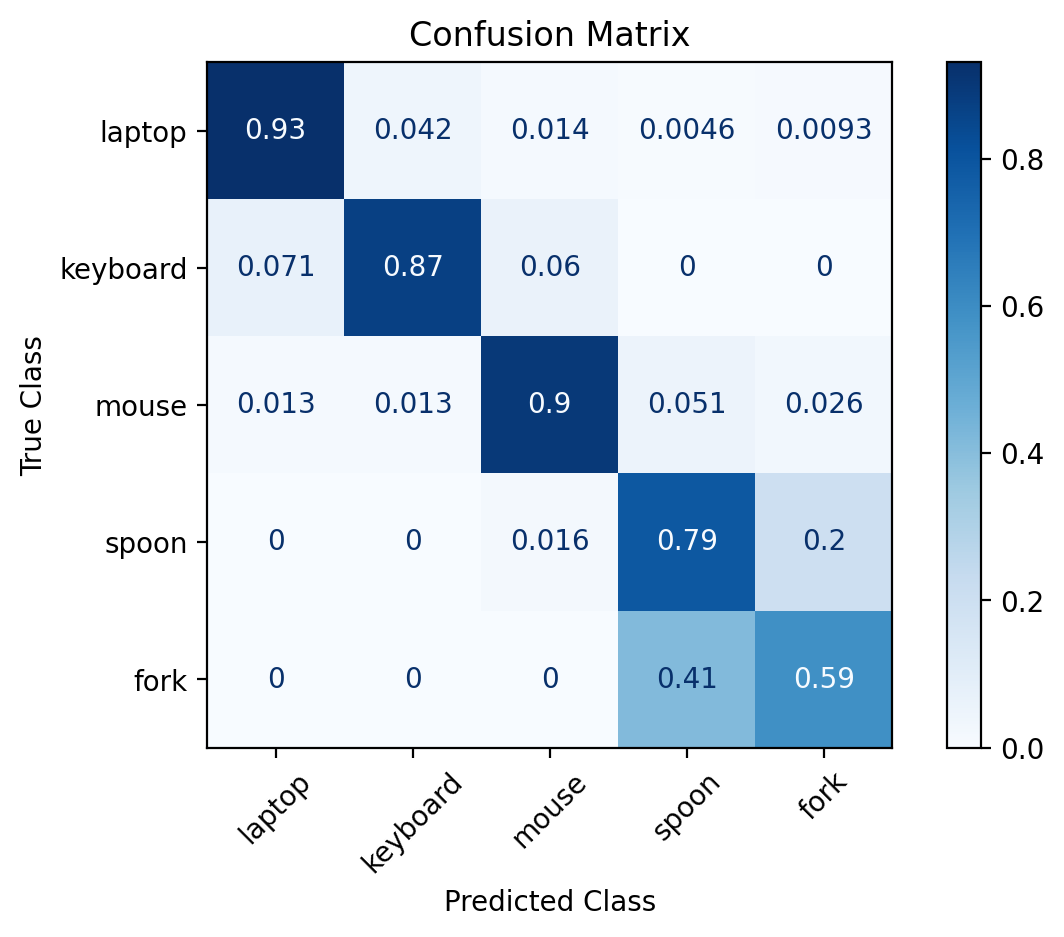

In [ ]:
# Collect predictions, targets, and IoU scores from the evaluation function
all_preds, all_labels, iou_scores = evaluate_and_collect(model_v2, data_loader_test, device)

# Compute F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Create a list of class names based on the index
class_names = [idx2name[i] for i in range(1, len(idx2name))]  # Exclude index 0

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(all_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

# Set the tick labels to class names
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [ ]:
import io
import sys

# Redirect stdout to capture the print output
output = io.StringIO()
sys.stdout = output

# Iterate over the metrics and summarize
for i, evaluator in enumerate(metrics):
    print(f"Evaluator {i}:")
    evaluator.summarize()

# Reset stdout
sys.stdout = sys.__stdout__

# Get the captured output
results = output.getvalue()

# Write to a text file
with open('evaluation_results.txt', 'w') as txt_file:
    txt_file.write(results)

print("Results saved to evaluation_results.txt")


In [ ]:
!cp -r '/content/evaluation_results.txt' '/content/drive/MyDrive/ColabNotebooks/FasterRCNN/FASTER_RCNN'